<center><h1> Final Project Repository </h1></center>

## Group Name: MLL(Matt, Lin, Lexie, also ml-lab)

## Student Name:
1. Lin Meng
2. Matt Sarmiento
3. Qingyi Sun 

<center><h2> Outline </h2></center>

1. Ask: How much energy will a building consume?
2. Acquire: Datasets including energy consumption, building and weather
3. Process: EDA, feature engineering and data merging
4. Model:
5. Deliver:

<center><h2>1. Ask: How much energy will a building consume?</h2></center>
  
We'd like to know whether investments being made to improve building efficiencies is actually effective at reducing costs and emissions.

<center><h2>2. Acquire: Datasets Introduction</h2></center>

- Data Source: Kaggle (ASHRAE - Great Energy Predictor III)
- 3 Datasets: meter, building, weather
- Number of Features Available: 16
- Number of Observations: 20M+

In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from time import time
import datetime
import gc

In [2]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split,KFold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## load data

In [3]:
building_metadata = pd.read_csv("data/building_metadata.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")
test = pd.read_csv("data/test.csv", parse_dates=['timestamp'])
train = pd.read_csv("data/train.csv", parse_dates=['timestamp'])
weather_test = pd.read_csv("data/weather_test.csv", parse_dates=['timestamp'])
weather_train = pd.read_csv("data/weather_train.csv", parse_dates=['timestamp'])

<center><h2>3. Process: EDA, Feature Engineering and Data Merging</h2></center>

### missing values

Text(0.5, 1.0, 'Density of Logartihm(Meter Reading + 1) Among Different Meters')

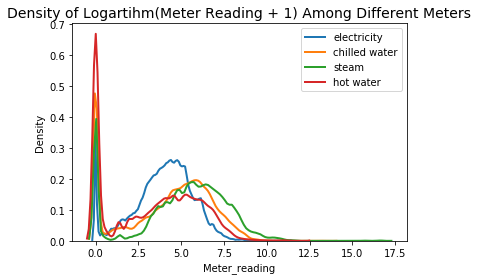

In [4]:
# distribution of the meter reading in meters without zeros

#list of different meters
meters = sorted(train['meter'].unique().tolist())

# plot meter_reading distribution for each meter
for meter_type in meters:
    subset = train[train['meter'] == meter_type]
    sns.kdeplot(np.log1p(subset["meter_reading"]), 
                label=meter_type, linewidth=2)

# set title, legends and labels
plt.ylabel("Density")
plt.xlabel("Meter_reading")
plt.legend(['electricity', 'chilled water', 'steam', 'hot water'])
plt.title("Density of Logartihm(Meter Reading + 1) Among Different Meters", size=14)

In [5]:
print(building_metadata.isna().sum())

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64


In [6]:
building_metadata.isna().sum()/len(building_metadata)

site_id        0.000000
building_id    0.000000
primary_use    0.000000
square_feet    0.000000
year_built     0.534161
floor_count    0.755003
dtype: float64

Since `floor_count` has 76% missing data, I am considering to drop this column.

In [7]:
building_metadata.drop('floor_count',axis=1,inplace=True)

In [8]:
print('weather_train set missing data')
print(weather_train.isna().sum())
print('-'*27)
print('weather_test set missing data')
print(weather_test.isna().sum())

weather_train set missing data
site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64
---------------------------
weather_test set missing data
site_id                    0
timestamp                  0
air_temperature          104
cloud_coverage        140448
dew_temperature          327
precip_depth_1_hr      95588
sea_level_pressure     21265
wind_direction         12370
wind_speed               460
dtype: int64


In [9]:
missing_weather = pd.DataFrame(weather_train.isna().sum()/len(weather_train), columns=["missing% in weather_train"])
missing_weather["missing% in weather_test"] = weather_test.isna().sum()/len(weather_test)
missing_weather

,missing% in weather_train,missing% in weather_test
site_id,0.000000,0.000000
timestamp,0.000000,0.000000
air_temperature,0.000393,0.000375
cloud_coverage,0.494895,0.506588
dew_temperature,0.000808,0.001179
precip_depth_1_hr,0.359791,0.344781
sea_level_pressure,0.075966,0.076702
wind_direction,0.044844,0.044618
wind_speed,0.002175,0.001659


In [10]:
missing_main = pd.DataFrame(train.isna().sum()/len(train), columns=["missing% in train"])
missing_main["missing% in test"] = test.isna().sum()/len(test)
missing_main

,missing% in train,missing% in test
building_id,0.0,0.0
meter,0.0,0.0
timestamp,0.0,0.0
meter_reading,0.0,NaN


### EDA

#### train set
* we already know there is no missing data in the train data set.

In [11]:
train.describe(include='all')

,building_id,meter,timestamp,meter_reading
count,2.021610e+07,2.021610e+07,20216100,2.021610e+07
unique,NaN,NaN,8784,NaN
top,NaN,NaN,2016-12-27 22:00:00,NaN
freq,NaN,NaN,2370,NaN
first,NaN,NaN,2016-01-01 00:00:00,NaN
last,NaN,NaN,2016-12-31 23:00:00,NaN
mean,7.992780e+02,6.624412e-01,NaN,2.117121e+03
std,4.269133e+02,9.309921e-01,NaN,1.532356e+05
min,0.000000e+00,0.000000e+00,NaN,0.000000e+00
25%,3.930000e+02,0.000000e+00,NaN,1.830000e+01


Text(0, 0.5, 'Frequency')

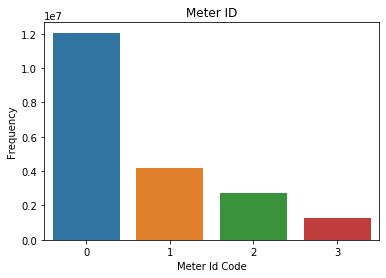

In [12]:
# 'meter' column is a dummy variable.
# 0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"
sns.countplot(train['meter'])
plt.title("Meter ID")
plt.xlabel("Meter Id Code")
plt.ylabel("Frequency")

In [13]:
# building ID
print(train['building_id'].nunique())

1449


Text(0.5, 1.0, 'log(meter_reading)')

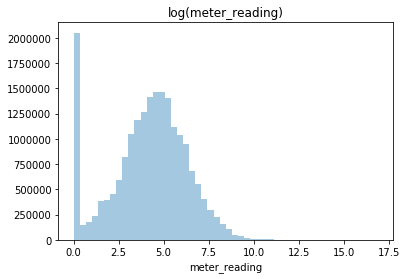

In [14]:
# meter_reading
sns.distplot(np.log1p(train['meter_reading']), kde=False)
plt.title("log(meter_reading)")

In [15]:
train.groupby('meter')['meter_reading'].agg(['count', 'min','max','mean','median','std'])

,count,min,max,mean,median,std
meter,,,,,,
0,12060910,0.0,79769.0,170.825636,62.8319,380.834307
1,4182440,0.0,880374.0,633.363924,120.4870,7988.213146
2,2708713,0.0,21904700.0,13882.187689,257.8120,418313.503638
3,1264037,0.0,160187.0,385.866781,39.6237,2508.172498


In [16]:
# timestamp
for record in [train, test]:
    record['Month'] = record['timestamp'].dt.month.astype("uint8")
    record['DayOfMonth'] = record['timestamp'].dt.day.astype("uint8")
    record['DayOfWeek'] = record['timestamp'].dt.dayofweek.astype("uint8")
    record['Hour'] = record['timestamp'].dt.hour.astype("uint8")

In [17]:
train.head()

,building_id,meter,timestamp,meter_reading,Month,DayOfMonth,DayOfWeek,Hour
0,0,0,2016-01-01,0.0,1,1,4,0
1,1,0,2016-01-01,0.0,1,1,4,0
2,2,0,2016-01-01,0.0,1,1,4,0
3,3,0,2016-01-01,0.0,1,1,4,0
4,4,0,2016-01-01,0.0,1,1,4,0


In [18]:
test.head()

,row_id,building_id,meter,timestamp,Month,DayOfMonth,DayOfWeek,Hour
0,0,0,0,2017-01-01,1,1,6,0
1,1,1,0,2017-01-01,1,1,6,0
2,2,2,0,2017-01-01,1,1,6,0
3,3,3,0,2017-01-01,1,1,6,0
4,4,4,0,2017-01-01,1,1,6,0


In [19]:
train.groupby(['DayOfWeek'])['meter_reading'].agg(['count', 'max','mean','median','std'])

,count,max,mean,median,std
DayOfWeek,,,,,
0,2871227,21904700.0,1967.816997,81.8800,143561.254033
1,2873589,21382500.0,2267.786315,84.2600,164549.218220
2,2876088,21847900.0,2485.819959,83.9688,176475.814571
3,2875944,21508500.0,2263.206170,84.0000,159903.297136
4,2927218,21889900.0,2151.439219,81.4900,156872.474338
5,2925717,21724400.0,1865.434390,69.0805,133678.418565
6,2866317,20629700.0,1820.957143,67.3064,132456.882993


In [20]:
train.groupby(['meter', 'DayOfWeek'])['meter_reading'].agg(['count', 'max','mean','median','std'])

count         max          mean     median            std
meter DayOfWeek                                                             
0     0          1711905     79769.0    175.686222   65.27000     399.705499
      1          1714778     19511.0    179.134665   67.65825     399.705281
      2          1715699     44336.5    179.199962   67.60000     403.142946
      3          1715180     17999.0    178.709908   67.48000     398.823510
      4          1745679     25275.0    174.842095   65.04000     392.604412
      5          1746705     31921.0    155.521126   55.29170     333.597049
      6          1710964     31921.0    152.859887   53.80000     329.086615
1     0           595214    793065.0    649.261667  125.83300    8312.484350
      1           594969    751685.0    671.752610  132.28000    8489.064247
      2           594893    849418.0    652.510875  130.40500    7700.235803
      3           595478    828374.0    645.291940  133.44850    7529.126686
      4           606214    880374.0    633.130978  123.95000    7951.400212
      5           603938    842194.0    591.998649  101.81300    7959.580462
      6           591734    740963.0    589.978521  100.54700    7935.345407
2     0           384571  21904700.0  12719.082862  265.35000  391956.394836
      1           384322  21382500.0  14937.290202  258.78900  449612.329514
      2           385848  21847900.0  16550.234958  259.25000  481477.287900
      3           385606  21508500.0  14908.276187  257.11500  436376.733265
      4           392299  21889900.0  14114.889103  265.35000  428203.815383
      5           392026  21724400.0  12137.564797  250.00000  364885.795929
      6           384041  20629700.0  11823.344224  246.69300  361567.409320
3     0           179537    116191.0    397.974351   41.60000    2631.279924
      1           179520    109348.0    384.962137   41.02990    2482.407597
      2           179648    108594.0    378.153655   40.11115    2393.341827
      3           179680    116081.0    386.000911   38.09920    2521.305546
      4           183026    160187.0    390.347224   39.20425    2450.829994
      5           183048    106629.0    384.118478   38.09920    2502.738844
      6           179578    108894.0    379.463869   38.09920    2569.318366

Text(0.5, 1.0, 'Distribution of Meter Reading per MeterID code: Chilledwater')

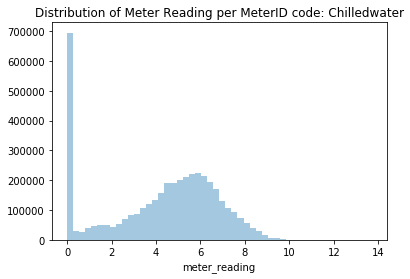

In [21]:
sns.distplot(np.log1p(train[train['meter'] == 1]['meter_reading']), kde=False)
plt.title("Distribution of Meter Reading per MeterID code: Chilledwater")

#### building_metadata

In [22]:
building_metadata.info()
# missing values in year_built

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 5 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
dtypes: float64(1), int64(3), object(1)
memory usage: 56.7+ KB


In [23]:
cols = ['site_id','primary_use','year_built']
for col in cols:
    print ("Unique Values in the {} column are:".format(col), building_metadata[col].unique())
    print ("\n")

Unique Values in the site_id column are: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


Unique Values in the primary_use column are: ['Education' 'Lodging/residential' 'Office'
 'Entertainment/public assembly' 'Other' 'Retail' 'Parking'
 'Public services' 'Warehouse/storage' 'Food sales and service'
 'Religious worship' 'Healthcare' 'Utility' 'Technology/science'
 'Manufacturing/industrial' 'Services']


Unique Values in the year_built column are: [2008. 2004. 1991. 2002. 1975. 2000. 1981. 1989. 2003. 2010. 1968. 1999.
 2013. 1974. 1996. 1980. 1977. 1990. 1985. 2001. 1969. 2005. 2016. 2006.
 2014. 1970. 1971. 2011. 1997. 2007. 1998. 2009. 1979. 1986. 1982. 1983.
   nan 1913. 1953. 1909. 1958. 1960. 1976. 1906. 1900. 1995. 1956. 1930.
 1967. 1919. 1955. 1965. 1907. 2012. 1992. 1948. 1950. 1941. 1957. 1964.
 1940. 1951. 1966. 1934. 1959. 1993. 1939. 1918. 1963. 1987. 1914. 1973.
 1988. 1935. 1942. 2015. 1931. 1928. 1929. 1908. 1927. 1923. 1962. 1944.
 1910. 1949. 2017. 1922. 1911. 1

Text(0, 0.5, 'Count')

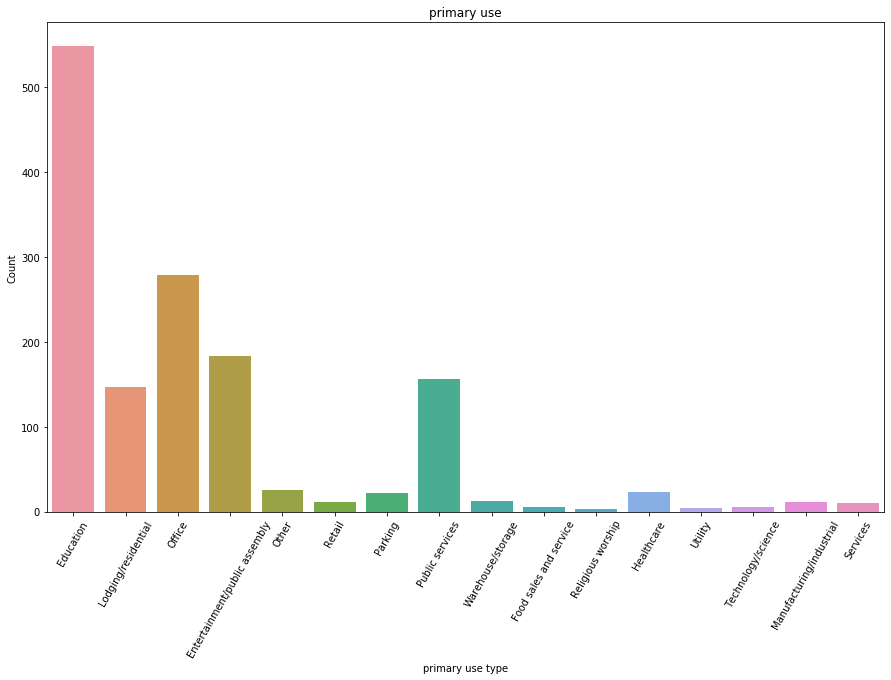

In [24]:
plt.figure(figsize=(15,9))
sns.countplot(building_metadata['primary_use'])
plt.title("primary use")
plt.xlabel("primary use type")
plt.xticks(rotation=60)
plt.ylabel("Count")

In [25]:
building_metadata['primary_use'].value_counts(normalize=True)
# only keep the top 5 types of primary use, and then set the others to 'other'
# keep: Education, Office, Entertainment/public assembly, Public services, Lodging/residential

Education                        0.378882
Office                           0.192547
Entertainment/public assembly    0.126984
Public services                  0.107660
Lodging/residential              0.101449
Other                            0.017253
Healthcare                       0.015873
Parking                          0.015183
Warehouse/storage                0.008972
Manufacturing/industrial         0.008282
Retail                           0.007591
Services                         0.006901
Technology/science               0.004141
Food sales and service           0.003451
Utility                          0.002761
Religious worship                0.002070
Name: primary_use, dtype: float64

In [26]:
building_metadata.loc[-building_metadata['primary_use'].isin(['Education', 'Office', 'Entertainment/public assembly', 'Public services', 'Lodging/residential']),['primary_use']] = 'other'

In [27]:
building_metadata['primary_use'].unique()

array(['Education', 'Lodging/residential', 'Office',
       'Entertainment/public assembly', 'other', 'Public services'],
      dtype=object)

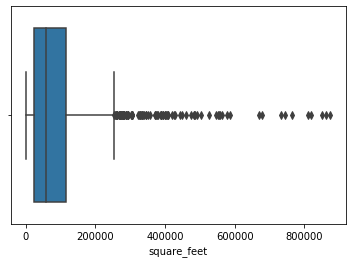

In [28]:
sns.boxplot(building_metadata['square_feet'])

Text(0, 0.5, 'Frequency')

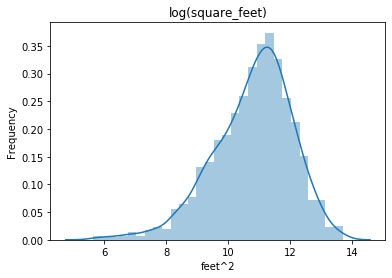

In [29]:
sns.distplot(np.log1p(building_metadata['square_feet']))
plt.title("log(square_feet)")
plt.xlabel("feet^2")
plt.ylabel("Frequency")

### Merge dataset & Preprocess data  
For the target：
- Remove observations where 'meter_reading' is 0.
- Implement log_transformation.

For the features:
- Create time featurs 'month', 'day of week', 'day of week' and 'hour' and drop feature 'timestamp'
- Change 'built-year' to a relative date, 'age'=2019-'built-year'
- Map all minority classes of feature 'primary_use' to 'Other' and label encode.
- Drop feature 'floor_count' since it has over 75% missing values.
- Drop unpredictive features.
- Use 'forward fill' mothod to impute the weather-related missing values.
- For missing values of other features, use mean to impute.

In [30]:
train = train.loc[train.meter_reading > 0]

In [31]:
# train['meter_reading_log1p'] = np.log1p(train['meter_reading'])
target = train.pop('meter_reading')

In [32]:
target = np.log1p(target)

In [33]:
%%time
train = pd.merge(train, building_metadata,on='building_id',how='left')
test  = pd.merge(test, building_metadata,on='building_id',how='left')
print ("Training Data Shape {}".format(train.shape))
print ("Testing Data Shape {}".format(test.shape))
gc.collect()

Training Data Shape (18342124, 11)
Testing Data Shape (41697600, 12)
CPU times: user 14.7 s, sys: 4.27 s, total: 19 s
Wall time: 11.1 s


80

In [34]:
%%time
train = pd.merge(train, weather_train, on=['site_id','timestamp'], how='left')
test  = pd.merge(test, weather_test, on=['site_id','timestamp'], how='left')
print ("Training Data Shape {}".format(train.shape))
print ("Testing Data Shape {}".format(test.shape))
gc.collect()

Training Data Shape (18342124, 18)
Testing Data Shape (41697600, 19)
CPU times: user 23.2 s, sys: 9.34 s, total: 32.5 s
Wall time: 18.1 s


20

In [35]:
train.drop('timestamp',axis=1,inplace=True)
test.drop('timestamp',axis=1,inplace=True)

In [36]:
columns = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']
for col in columns:
    train[col].fillna(method='ffill', inplace=True)
    train[col].fillna(method='bfill', inplace=True)
    test[col].fillna(method='ffill', inplace=True)
    test[col].fillna(method='bfill', inplace=True)

In [37]:
primary_use_list = train['primary_use'].unique()
primary_use_dict = {key: value for value, key in enumerate(primary_use_list)} 
train['primary_use'] = train['primary_use'].map(primary_use_dict)
test['primary_use'] = test['primary_use'].map(primary_use_dict)

In [38]:
train['primary_use'].unique()

array([0, 1, 2, 3, 4, 5])

In [39]:
train.drop('building_id',axis=1,inplace=True)
test.drop('building_id',axis=1,inplace=True)
train.drop('site_id',axis=1,inplace=True)
test.drop('site_id',axis=1,inplace=True)

In [40]:
train['year_built'].fillna(train['year_built'].median(),inplace = True)
test['year_built'].fillna(train['year_built'].median(),inplace = True)

In [41]:
train['age'] = 2019-train['year_built']

In [42]:
test['age'] = 2019-test['year_built']

In [43]:
train.drop('year_built',axis=1,inplace=True)
test.drop('year_built',axis=1,inplace=True)

In [44]:
train.head()

,meter,Month,DayOfMonth,DayOfWeek,Hour,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,age
0,0,1,1,4,0,0,9045,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,3.0
1,0,1,1,4,0,0,387638,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,22.0
2,0,1,1,4,0,1,33370,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,37.0
3,0,1,1,4,0,2,50623,3.8,6.0,2.4,-1.0,1020.9,240.0,3.1,51.0
4,0,1,1,4,0,2,5374,3.8,6.0,2.4,-1.0,1020.9,240.0,3.1,51.0


In [45]:
test.head()

,row_id,meter,Month,DayOfMonth,DayOfWeek,Hour,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,age
0,0,0,1,1,6,0,2,7432,17.8,4.0,11.7,0.0,1021.4,100.0,3.6,11.0
1,1,0,1,1,6,0,2,2720,17.8,4.0,11.7,0.0,1021.4,100.0,3.6,15.0
2,2,0,1,1,6,0,2,5376,17.8,4.0,11.7,0.0,1021.4,100.0,3.6,28.0
3,3,0,1,1,6,0,2,23685,17.8,4.0,11.7,0.0,1021.4,100.0,3.6,17.0
4,4,0,1,1,6,0,2,116607,17.8,4.0,11.7,0.0,1021.4,100.0,3.6,44.0


<center><h2>4. Model: Fit, Evaluation and Prediction</h2></center>

### Fit scikit-learn Model & Evaluation Matric (K-fold cross validation)

#### North Star metric
The evaluation metric for this competition is Root Mean Squared Logarithmic Error.  
The RMSLE is calculated as

$RMSLE = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }$

In [46]:
# train test split
X_train, X_valid, y_train, y_valid = train_test_split(train, target, test_size=0.2, shuffle=False)

### 1. Linear Regression

In [47]:
def fit_evaluate_model(model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_valid)
    return np.sqrt(((y_predicted - y_valid) ** 2).mean())

In [48]:
%%time
# create model apply fit_evaluate_model
linear_regression = LinearRegression()
lr_rmse = fit_evaluate_model(linear_regression, X_train, y_train, X_valid, y_valid)
print("RMSE of the linear regression model is:", lr_rmse)

RMSE of the linear regression model is: 1.5130834396103212
CPU times: user 26.4 s, sys: 3.74 s, total: 30.1 s
Wall time: 7.07 s


### 2. Random Forest

#### Build a pipeline

In [49]:
train.columns

Index(['meter', 'Month', 'DayOfMonth', 'DayOfWeek', 'Hour', 'primary_use',
       'square_feet', 'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'age'],
      dtype='object')

In [50]:
numeric_features = ["square_feet", "age", 'sea_level_pressure', 'wind_direction', 'wind_speed',
                    "air_temperature", "cloud_coverage", "dew_temperature", "precip_depth_1_hr", 
                    'Month', 'DayOfMonth', 'DayOfWeek', 'Hour']
numeric_transformer = Pipeline(steps=[("scaler", preprocessing.StandardScaler())
])

categorical_features = ["meter", "primary_use"]
preprocessor = compose.ColumnTransformer(transformers=[
    ("numerical", numeric_transformer, numeric_features)])

regressor = RandomForestRegressor(n_estimators=10,
                                  min_samples_leaf=168,
                                  random_state=42, 
                                  n_jobs=16)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", regressor)
])

In [51]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['square_feet', 'age',
                                                   'sea_level_pressure',
                                     

In [52]:
y_pred_train = pipeline.predict(X_train)
y_pred = pipeline.predict(X_valid)

In [53]:
rmsle_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print(f"RMSLE for the training set is {rmsle_train:.4f}")
rmsle = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f"RMSLE for the validation set is {rmsle:.4f}")

RMSLE for the training set is 0.9067
RMSLE for the validation set is 1.0783


### 3. Light Gradient Boosting

In [54]:
categorical_features = ['Month', 'DayOfMonth', 'DayOfWeek', 'Hour', 'cloud_coverage', "meter", "primary_use"]
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": 'rmse',
}

**3fold CV:**

In [55]:
kf = KFold(n_splits=3)
models = [] 
print('Model Evaluation of Light Gradient Boosting Model')
for train_index,test_index in kf.split(train):
    train_features = train.loc[train_index]
    train_target = target.loc[train_index]
    
    test_features = train.loc[test_index]
    test_target = target.loc[test_index]
    
    d_training = lgb.Dataset(train_features, label=train_target,categorical_feature=categorical_features, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target,categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
    models.append(model)
    del train_features, train_target, test_features, test_target, d_training, d_test
    gc.collect()

Model Evaluation of Light Gradient Boosting Model


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':
/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 2.05446	valid_1's rmse: 2.25745
[50]	training's rmse: 2.04043	valid_1's rmse: 2.25805
[75]	training's rmse: 2.03155	valid_1's rmse: 2.25891
Early stopping, best iteration is:
[30]	training's rmse: 2.05111	valid_1's rmse: 2.25718
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 2.13534	valid_1's rmse: 2.11108
[50]	training's rmse: 2.1195	valid_1's rmse: 2.11599
Early stopping, best iteration is:
[2]	training's rmse: 2.16664	valid_1's rmse: 2.10343
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 2.14439	valid_1's rmse: 2.07962
[50]	training's rmse: 2.12791	valid_1's rmse: 2.08147
Early stopping, best iteration is:
[22]	training's rmse: 2.14718	valid_1's rmse: 2.07947


**train-test split**

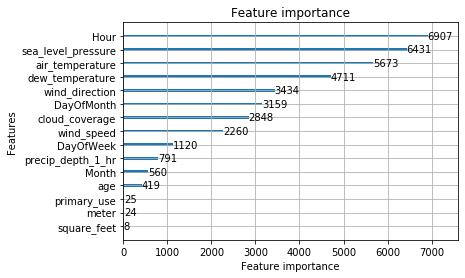

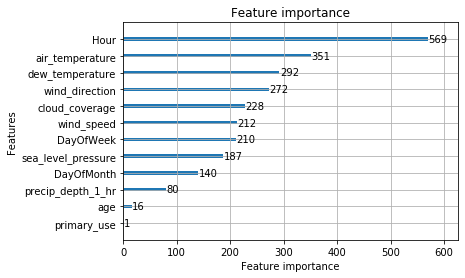

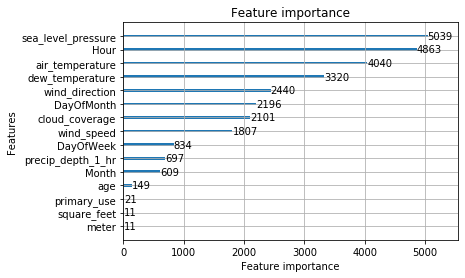

In [56]:
for model in models:
    lgb.plot_importance(model)
    plt.show()

In [60]:
models_2 = [] 
train_features = X_train
train_target = y_train
validation_features = X_valid
validation_target = y_valid
print('Model Evaluation of Light Gradient Boosting Model(1-fold)')
d_training = lgb.Dataset(train_features, label=train_target, categorical_feature=categorical_features, free_raw_data=False)
d_test = lgb.Dataset(validation_features, label=validation_target, categorical_feature=categorical_features, free_raw_data=False)
    
model = lgb.train(params, train_set=d_training, num_boost_round=150, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
models_2.append(model)


Model Evaluation of Light Gradient Boosting Model(1-fold)
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.891106	valid_1's rmse: 0.9606
[50]	training's rmse: 0.66019	valid_1's rmse: 0.773553
[75]	training's rmse: 0.574847	valid_1's rmse: 0.715275
[100]	training's rmse: 0.531258	valid_1's rmse: 0.691125
[125]	training's rmse: 0.506273	valid_1's rmse: 0.680731
[150]	training's rmse: 0.490459	valid_1's rmse: 0.674796
Did not meet early stopping. Best iteration is:
[150]	training's rmse: 0.490459	valid_1's rmse: 0.674796


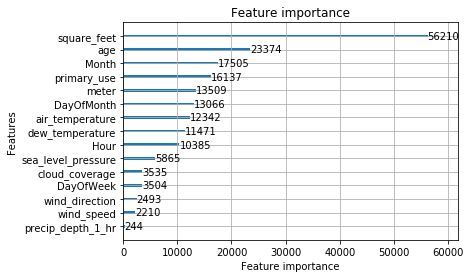

In [62]:
lgb.plot_importance(models_2[0])    
plt.show()

### Prediction

In [63]:
results = []
for model in models:
    if  results == []:
        results = np.expm1(model.predict(test, num_iteration=model.best_iteration)) / len(models)
    else:
        results += np.expm1(model.predict(test, num_iteration=model.best_iteration)) / len(models)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


<center><h2>5. Diliver: </h2></center>

#### 1. Light gradient boost is our best model.

#### 2. Visual the result

In [77]:
test = pd.read_csv("data/test.csv", parse_dates=['timestamp'])
full_test = test.assign(meter_reading=results)

In [78]:
train = pd.read_csv("data/train.csv", parse_dates=['timestamp'])
train_avg_1 = train.groupby("meter").agg({"meter_reading":"mean"}).reset_index()

test_avg_1 = full_test.groupby("meter").agg({"meter_reading":"mean"}).reset_index()
train_avg_1 = train_avg_1.assign(flag="2016 Observed")
test_avg_1 = test_avg_1.assign(flag="2017-18 Predicted")
df_meter = pd.concat([train_avg_1, test_avg_1])

# replace the meter type: {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}
df_meter["meter"].replace({0: "electricity", 1: "chilledwater", 2: "steam", 3: "hotwater"}, inplace=True)

In [84]:
df_meter['log_reading'] = np.log1p(df_meter['meter_reading'])

In [79]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [80]:
full_test.head()

,row_id,building_id,meter,timestamp,meter_reading
0,0,0,0,2017-01-01,47.638252
1,1,1,0,2017-01-01,47.638252
2,2,2,0,2017-01-01,47.638252
3,3,3,0,2017-01-01,47.638252
4,4,4,0,2017-01-01,47.638252


In [83]:
df_meter.head()

,meter,meter_reading,flag
0,electricity,170.825636,2016 Observed
1,chilledwater,633.363924,2016 Observed
2,steam,13882.187689,2016 Observed
3,hotwater,385.866781,2016 Observed
0,electricity,58.154302,2017-18 Predicted


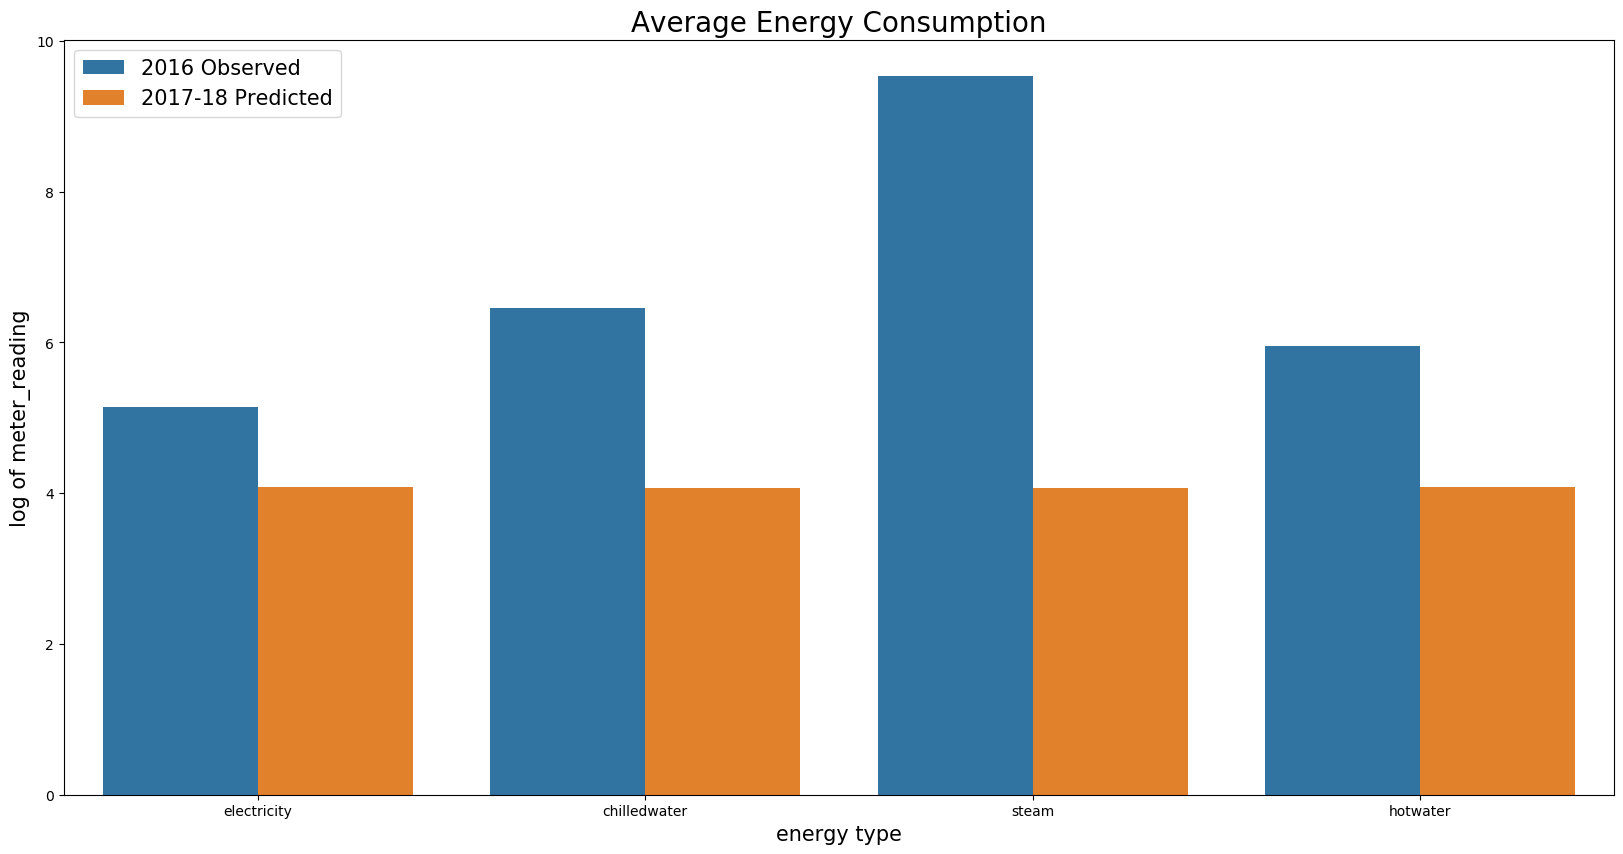

In [85]:
plt.figure(figsize=(20,10), dpi=100)
sns.barplot(x='meter', y='log_reading', hue='flag', data=df_meter)
# sns.barplot(x='meter', y='meter_reading', data=test_avg_1)
plt.xlabel("energy type", fontsize=15)
plt.ylabel("log of meter_reading", fontsize=15)
plt.title("Average Energy Consumption", fontsize=20)
plt.legend(loc="upper left", fontsize=15)
plt.show()

**Our Conclusion: according to our predictions, there is a drop of the energy consuming.**